In [1]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
random.seed(38)
torch.manual_seed(38)
# use for random generation
fixed_noise = Variable(torch.randn(32, 100, 1, 1)).cuda()

In [3]:
# load data
train_X = np.load("train_img.npy")
test_X = np.load("test_img.npy")
train_X = torch.from_numpy(train_X).type(torch.FloatTensor)
test_X = torch.from_numpy(test_X).type(torch.FloatTensor)

In [4]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output
    
class Discriminator(nn.Module):
    def __init__(self, figsize=64):
        super(Discriminator, self).__init__()
        self.decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(figsize * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, X):
        output = self.decoder(X)

        return output.view(-1, 1).squeeze(1)

In [6]:
# training
latent_size = 100

G = Generator().cuda()
D = Discriminator().cuda()
criterion = nn.BCELoss()
# setup optimizer
optimizerG = optim.Adam(G.parameters(), lr=0.0002)
optimizerD = optim.Adam(D.parameters(), lr=0.0002)

BATCH_SIZE = 64



D_loss_list = []
G_loss_list = []
D_fake_acc_list = []
D_real_acc_list = []
for epoch in range(100):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = train_X[perm_index]

    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        D.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        
        #### train with real image -> ground truth = real label
        real_image = Variable(input_X.cuda()) # use GPU 
        real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
        output = D(real_image)
        D_real_loss = criterion(output, real_label)
        D_real_acc += np.mean(((output > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
        
        #### train with fake image -> ground truth = fake label
        noise = Variable(torch.randn(BATCH_SIZE, 100, 1, 1)).cuda()
        fake_image = G(noise)
        fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
        output = D(fake_image.detach())
        D_fake_loss = criterion(output, fake_label)
        D_fake_acc += np.mean(((output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
        
        # update D
        D_train_loss = D_real_loss + D_fake_loss
        epoch_D_loss+=(D_train_loss.data[0])
        D_train_loss.backward()
        optimizerD.step()
        
        #### train Generator
        for _ in range(2):
            G.zero_grad()
            # generate fake image
            noise = Variable(torch.randn(BATCH_SIZE, 100, 1, 1)).cuda()
            fake_image = G(noise)
            fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()
            output = D(fake_image)
            G_loss = criterion(output, fake_label_for_G)
            epoch_G_loss += (G_loss.data[0])
            G_loss.backward()
            optimizerG.step()
        
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    
    print("D_real_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_noise)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './GAN_output/fig2_3_'+str(epoch+1)+'.jpg',nrow=8)
    
torch.save(G.state_dict(), "./models/G_model.pkt")

Epoch: 1
training D Loss: 0.022429780016839505
training G Loss: 0.057360511489212514
D_real_acc: 0.63635
D_fake_acc: 0.67535
Epoch: 2
training D Loss: 0.026458882911503313
training G Loss: 0.03266827874705196
D_real_acc: 0.52795
D_fake_acc: 0.524
Epoch: 3
training D Loss: 0.024782386577129365
training G Loss: 0.028676536732912063
D_real_acc: 0.50285
D_fake_acc: 0.49025
Epoch: 4
training D Loss: 0.024214299200475214
training G Loss: 0.02834881398305297
D_real_acc: 0.514225
D_fake_acc: 0.516
Epoch: 5
training D Loss: 0.023489257593452932
training G Loss: 0.026014787551760673
D_real_acc: 0.5062
D_fake_acc: 0.5235
Epoch: 6
training D Loss: 0.024017149940133094
training G Loss: 0.023725964000076056
D_real_acc: 0.44375
D_fake_acc: 0.42245
Epoch: 7
training D Loss: 0.02197147992551327
training G Loss: 0.027947529888153078
D_real_acc: 0.5445
D_fake_acc: 0.5943
Epoch: 8
training D Loss: 0.019754899586737155
training G Loss: 0.0341682422220707
D_real_acc: 0.621475
D_fake_acc: 0.70075
Epoch: 9
tr

training D Loss: 0.012992074638605118
training G Loss: 0.052301936715841296
D_real_acc: 0.815925
D_fake_acc: 0.825275
Epoch: 68
training D Loss: 0.012779454164206982
training G Loss: 0.05228737054765224
D_real_acc: 0.8212
D_fake_acc: 0.828525
Epoch: 69
training D Loss: 0.012120179220288992
training G Loss: 0.053873462709784506
D_real_acc: 0.83845
D_fake_acc: 0.845125
Epoch: 70
training D Loss: 0.011785447578132153
training G Loss: 0.05495247003734112
D_real_acc: 0.8438
D_fake_acc: 0.850625
Epoch: 71
training D Loss: 0.011921956991404295
training G Loss: 0.05632079827785492
D_real_acc: 0.839225
D_fake_acc: 0.8462
Epoch: 72
training D Loss: 0.011428727636486292
training G Loss: 0.05708022784590721
D_real_acc: 0.850475
D_fake_acc: 0.859425
Epoch: 73
training D Loss: 0.01110428690314293
training G Loss: 0.05828851409256458
D_real_acc: 0.85785
D_fake_acc: 0.861875
Epoch: 74
training D Loss: 0.010702929855883121
training G Loss: 0.05970861616432667
D_real_acc: 0.865625
D_fake_acc: 0.873925
E

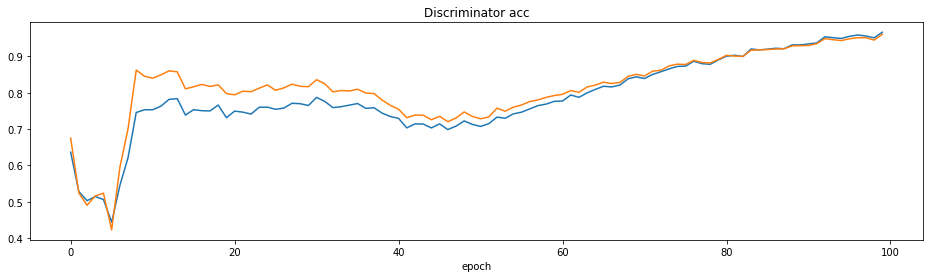

In [9]:
# plot loss
plt.figure(figsize=(16,4))

plt.plot(D_real_acc_list)
plt.plot(D_fake_acc_list)
plt.title("Discriminator acc")
plt.xlabel("epoch")
plt.savefig("./GAN_output/fig2_2.jpg")
plt.show()

### Reference
https://github.com/pytorch/examples/tree/master/dcgan